In [1]:
import cv2, sys, os, time
import numpy as np
import pickle
import matplotlib.pyplot as plt 

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from utils.detection_tools import extract_object_and_background_masks
from utils.detection_tools import detect_sky, estimate_horizon_line_by_edges
from utils.detection_tools import rectify_horizon, downsampler, rotate_and_center_horizon
from utils.common_tools import annotate_image, show_bgr
from utils.common_tools import find_nonzero_bounding_box, trim_video, draw_parallel_lines

from utils.detection_tools import get_min_max_hsv, extract_contour_region
from auto_startup.config import ImageProcessingParams
from utils.detection_tools import detect_sky, estimate_horizon_line_by_edges
from utils.detection_tools import  downsampler, rotate_and_center_horizon
from utils.common_tools import annotate_image, show_bgr, draw_parallel_lines
from utils.detection_tools import  plot_min_max_lab_colors, create_lab_range_mask, expand_mask
from utils.detection_tools import get_min_max_lab_values, create_donut_mask_with_exclusion

from src.detect_basic import detect_basic



In [11]:
# load in foi_2.png with opencv
#frame = frame[0:200,0:600] #for foi_2b
#show_bgr(frame,w=10)

#get first frame from basic_dot.mp4
#cap = cv2.VideoCapture('synth_track_video.mp4')
#ret, frame = cap.read()

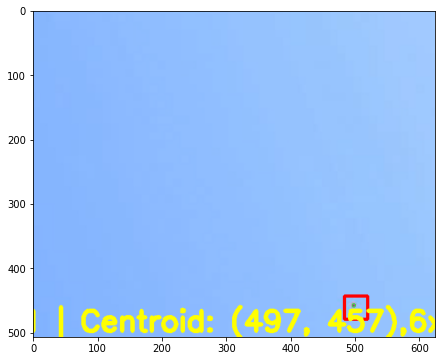

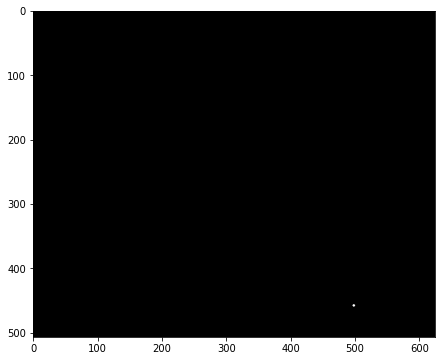

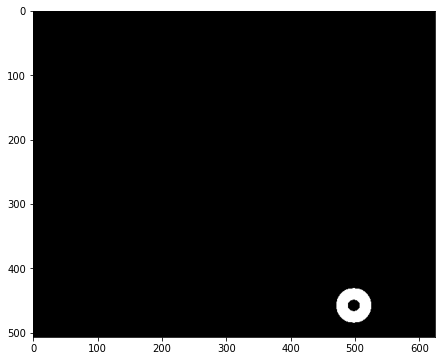

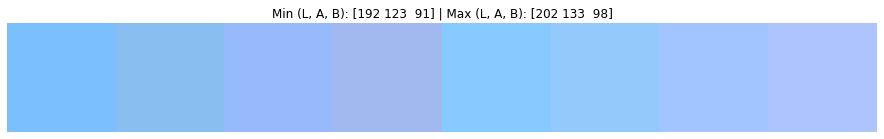

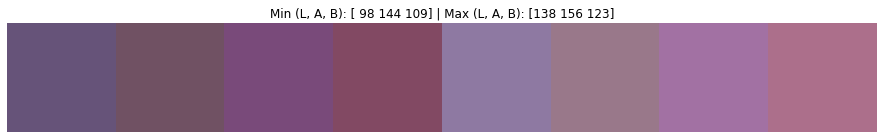

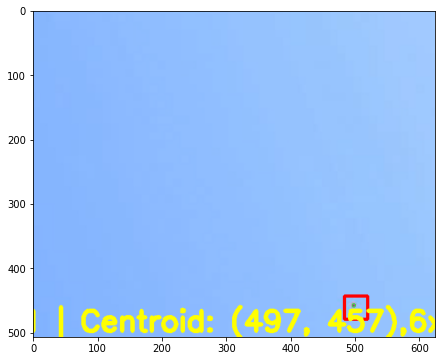

In [12]:
frame = cv2.imread('foi_2.png')
complete_frame, x,y,w,h, contour_mask, identified_object = detect_basic(frame,1,debug=False,
                                                                        debug_image_width=20)

show_bgr(complete_frame, w=10)
#shrink the contour mask by 1 pixel 
contour_mask = cv2.erode(contour_mask, np.ones((3,3), np.uint8), iterations=1)
show_bgr(contour_mask, w=10)

background_mask = create_donut_mask_with_exclusion(frame, identified_object,
                                       outer_pad_ratio=2,
                                       exclusion_pad_ratio=1)

show_bgr(background_mask, w=10)


b_min, b_max = get_min_max_lab_values(frame, background_mask)
o_min, o_max = get_min_max_lab_values(frame, contour_mask)

plot_min_max_lab_colors(b_min, b_max)
plot_min_max_lab_colors(o_min, o_max)
show_bgr(complete_frame, w=10)

In [13]:
#frame = cv2.imread('foi_2b.png')
#load in video auto_startup/synth_track_video.mp4

cap = cv2.VideoCapture("synth_track_video_clouds.mp4")


for i in range(0, 61):
            if i % 10 == 0:
                print(f"Processing frame {i}...")

            frame_number = i
            # Set the frame position (0-based index)
            frame_index = frame_number - 1
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

            # Read the frame
            ret, raw_frame = cap.read()
            if not ret:
                print(f"Frame {frame_index} could not be read.")
                continue


            complete_frame, x,y,w,h, contour_mask, identified_object= detect_basic(raw_frame,1,debug=False,
                                                                                    debug_image_width=20,
                                                                                    b_range = (b_min, b_max),
                                                                                    o_range = (o_min, o_max))
            print(x,y)
            #show_bgr(complete_frame, w=10)


Processing frame 0...
1181 896
1181 896
1548 834
1719 611
1850 697
1836 680
1774 485
1786 453
1798 435
1902 595
Processing frame 10...
1910 609
1909 636
0 0
1782 800
1762 884
1793 966
1685 1072
0 0
1281 968
1226 1008
Processing frame 20...
1166 1042
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
Processing frame 30...
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
Processing frame 40...
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
Processing frame 50...
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
Processing frame 60...
0 0
